## Imports

In [1]:
import shap
import catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statkit.decision
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from statkit.decision import NetBenefitDisplay
import scipy.stats as stats
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc,brier_score_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from dcurves import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Functions

In [2]:
def custom_impute_split(df, test_size=0.2, random_state=42):
    # Split the DataFrame into train and test sets
    train, test = train_test_split(df, test_size=test_size, random_state=random_state)
    # Split the train set into train and validation sets
    train, validation = train_test_split(train, test_size=0.1, random_state=random_state)
    # Initialize a SimpleImputer for imputation
    imputer = SimpleImputer(strategy='mean')
    # Perform imputation on the train set
    columns_with_missing_values = [column for column in train.columns if train[column].isnull().any()]
    imputer.fit(train[columns_with_missing_values])
    imputed_train = imputer.transform(train[columns_with_missing_values])
    # Use the same imputer to impute the test and validation sets based on the train set
    imputed_test = imputer.transform(test[columns_with_missing_values])
    imputed_validation = imputer.transform(validation[columns_with_missing_values])
    # Add indicator columns for imputed features
    for column in columns_with_missing_values:
        indicator_column = column + '_imputed'
        train[indicator_column] = train[column].isnull().astype(int)
        test[indicator_column] = test[column].isnull().astype(int)
        validation[indicator_column] = validation[column].isnull().astype(int)
    # Update the columns in the imputed sets
    train[columns_with_missing_values] = imputed_train
    test[columns_with_missing_values] = imputed_test
    validation[columns_with_missing_values] = imputed_validation
    return train, test, validation

## Read data

In [3]:
measures_df = pd.read_csv('data_for_model/measurements_df.csv', index_col=0)
lungs_df = pd.read_csv('data_for_model/lungs_df.csv', index_col=0)
limbs_df = pd.read_csv('data_for_model/limbs_df.csv', index_col=0).drop(columns=['LIMBS_PLACE'])
jugular_df = pd.read_csv('data_for_model/jugular_df.csv', index_col=0)
labs_df = pd.read_csv('data_for_model/labs_df.csv', index_col=0)
diag_df = pd.read_csv('data_for_model/diag_df.csv', index_col=0)
med_df = pd.read_csv('data_for_model/med_df.csv', index_col=0)
labeled_case_no = pd.read_csv('labels/labeled_case_no.csv', index_col=0)
patients_indo = pd.read_csv('data_for_model/patients_info.csv', index_col=0)

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
merged_data = pd.merge(labeled_case_no, diag_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, lungs_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, limbs_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, jugular_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, labs_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, measures_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, med_df, on='case_no', how='left')
merged_data = pd.merge(merged_data, patients_indo, on='case_no', how='left')

In [5]:
merged_data.drop(columns=['admission_time', 'case_no'], inplace=True, errors='ignore')

In [ ]:
# fill 0 in diags, med, lungs, limbs, jugular
merged_data[diag_df.columns[1:]] = merged_data[diag_df.columns[1:]].fillna(0)
merged_data[diag_df.columns[1:]] = merged_data[diag_df.columns[1:]].astype(int)
merged_data[med_df.columns[1:]] = merged_data[med_df.columns[1:]].fillna(0)
merged_data[med_df.columns[1:]] = merged_data[med_df.columns[1:]].astype(int)
merged_data[lungs_df.columns[1:]] = merged_data[lungs_df.columns[1:]].fillna(0)
merged_data[lungs_df.columns[1:]] = merged_data[lungs_df.columns[1:]].astype(int)
merged_data[limbs_df.columns[1:]] = merged_data[limbs_df.columns[1:]].fillna(0)
merged_data[limbs_df.columns[1:]] = merged_data[limbs_df.columns[1:]].astype(int)
merged_data[jugular_df.columns[1:]] = merged_data[jugular_df.columns[1:]].fillna(0)
merged_data[jugular_df.columns[1:]] = merged_data[jugular_df.columns[1:]].astype(int)

## Imputations

## Split data into train, validation and test

In [9]:
X = merged_data.drop(columns=['case_no', 'admission_time'], errors='ignore')
y = merged_data[['label']]

In [10]:
X_train_imputed, X_test_imputed, X_val_imputed = custom_impute_split(X)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [11]:
y_train = X_train_imputed[['label']]
X_train_imputed = X_train_imputed.drop(columns=['label', 'case_no', 'admission_time'], errors='ignore')
y_val = X_val_imputed[['label']]
X_val_imputed = X_val_imputed.drop(columns=['label', 'case_no', 'admission_time'], errors='ignore')
y_test = X_test_imputed[['label']]
X_test_imputed = X_test_imputed.drop(columns=['label', 'case_no', 'admission_time'], errors='ignore')

In [12]:
y_test['label'].value_counts()

0    2390
1     908
Name: label, dtype: int64

## Normalization

In [13]:
### Train data normalization
# Filter columns that don't end with "_imputed"
selected_columns = [col for col in X_train_imputed.columns if not col.endswith('_imputed')]
flag_columns = [col for col in X_train_imputed.columns if col.endswith('_imputed')]
# Calculate Z-scores for the selected columns
z_scores = X_train_imputed[selected_columns].apply(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else x)
X_train_flag = X_train_imputed[flag_columns]
X_train_norm = pd.concat([z_scores, X_train_flag], axis=1)

In [14]:
## Validation data normalization
selected_columns = [col for col in X_val_imputed.columns if not col.endswith('_imputed')]
flag_columns = [col for col in X_val_imputed.columns if col.endswith('_imputed')]
# Calculate Z-scores for the selected columns
z_scores = X_val_imputed[selected_columns].apply(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else x)
X_val_flag = X_val_imputed[flag_columns]
X_val_norm = pd.concat([z_scores, X_val_flag], axis=1)

In [15]:
## Test data normalization
selected_columns = [col for col in X_test_imputed.columns if not col.endswith('_imputed')]
flag_columns = [col for col in X_test_imputed.columns if col.endswith('_imputed')]
# Calculate Z-scores for the selected columns
z_scores = X_test_imputed[selected_columns].apply(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else x)
X_test_flag = X_test_imputed[flag_columns]
X_test_norm = pd.concat([z_scores, X_test_flag], axis=1)

## Models

### XGBoost

In [354]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [200, 600, 1000],
    'max_depth': [6, 8, 10], 'min_child_weight': [4, 6, 8]}
xgb_model = XGBClassifier(learning_rate=0.01, n_estimators=600, max_depth=6, min_child_weight=6)

### Random Forest

In [355]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_rf_model = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)

In [357]:
rf_model = RandomForestClassifier(max_depth=70, max_features= 3, min_samples_split= 12, n_estimators= 600)

## Logistic regression

In [358]:
param_grid={"C":np.logspace(-3,3,7), "penalty":["l1"], "solver":['liblinear'], "max_iter":[1000, 1200, 1400]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, param_grid, cv=5)

In [359]:
l1_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, C=0.05)

## Fit model

In [ ]:
%%time
xgb_model.fit(X_train_norm, y_train['label'])
l1_model.fit(X_train_norm, y_train['label'])
rf_model.fit(X_train_norm, y_train['label'])

## Validation

In [367]:
## xgb
xgb_y_pred = xgb_model.predict(X_val_norm)
print(classification_report(y_pred=xgb_y_pred, y_true=y_val['label']))
xgb_y_val_pred = xgb_model.predict_proba(X_val_norm)[:, 1]
print(round(roc_auc_score(y_true=y_val['label'], y_score=xgb_y_val_pred), 4))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       957
           1       0.37      0.05      0.09       362

    accuracy                           0.72      1319
   macro avg       0.55      0.51      0.46      1319
weighted avg       0.63      0.72      0.63      1319

0.594


In [368]:
## l1
l1_y_pred = l1_model.predict(X_val_norm)
print(classification_report(y_pred=l1_y_pred, y_true=y_val['label']))
l1_y_val_pred = l1_model.predict_proba(X_val_norm)[:, 1]
print(round(roc_auc_score(y_true=y_val['label'], y_score=l1_y_val_pred), 3))

              precision    recall  f1-score   support

           0       0.73      0.97      0.84       957
           1       0.45      0.06      0.10       362

    accuracy                           0.72      1319
   macro avg       0.59      0.52      0.47      1319
weighted avg       0.65      0.72      0.63      1319

0.586


In [369]:
## RF
rf_y_pred = rf_model.predict(X_val_norm)
print(classification_report(y_pred=rf_y_pred, y_true=y_val['label']))
rf_y_val_pred = rf_model.predict_proba(X_val_norm)[:, 1]
print(round(roc_auc_score(y_true=y_val['label'], y_score=rf_y_val_pred), 3))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84       957
           1       0.57      0.01      0.02       362

    accuracy                           0.73      1319
   macro avg       0.65      0.50      0.43      1319
weighted avg       0.68      0.73      0.62      1319

0.581


## Prediction

In [370]:
## xgb
xgb_y_pred = xgb_model.predict(X_test_norm)
print(classification_report(y_pred=xgb_y_pred, y_true=y_test['label']))
xgb_y_test_pred = xgb_model.predict_proba(X_test_norm)[:, 1]
print(round(roc_auc_score(y_true=y_test['label'], y_score=xgb_y_test_pred), 3))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82      2390
           1       0.39      0.14      0.21       908

    accuracy                           0.70      3298
   macro avg       0.57      0.53      0.51      3298
weighted avg       0.64      0.70      0.65      3298

0.57


In [371]:
## l1
l1_y_pred = l1_model.predict(X_test_norm)
print(classification_report(y_pred=l1_y_pred, y_true=y_test['label']))
l1_y_test_pred = l1_model.predict_proba(X_test_norm)[:, 1]
print(round(roc_auc_score(y_true=y_test['label'], y_score=l1_y_test_pred), 4))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      2390
           1       0.60      0.05      0.10       908

    accuracy                           0.73      3298
   macro avg       0.67      0.52      0.47      3298
weighted avg       0.70      0.73      0.64      3298

0.6039


In [372]:
## rf
rf_y_pred = rf_model.predict(X_test_norm)
print(classification_report(y_pred=rf_y_pred, y_true=y_test['label']))
rf_y_test_pred = rf_model.predict_proba(X_test_norm)[:, 1]
print(round(roc_auc_score(y_true=y_test['label'], y_score=rf_y_test_pred), 4))

              precision    recall  f1-score   support

           0       0.72      0.99      0.84      2390
           1       0.32      0.01      0.01       908

    accuracy                           0.72      3298
   macro avg       0.52      0.50      0.43      3298
weighted avg       0.61      0.72      0.61      3298

0.5835


## Interpretation

In [373]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val_norm)

[11:17:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


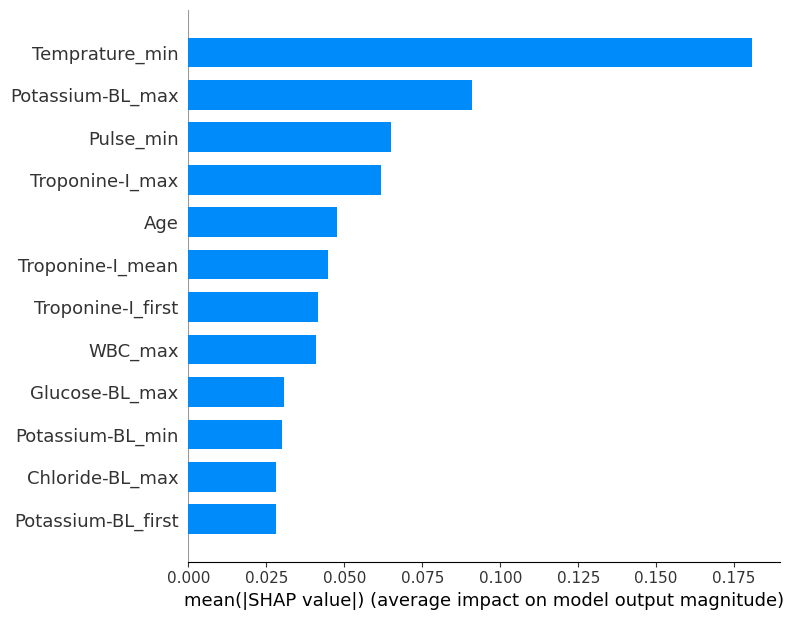

In [390]:
shap.summary_plot(shap_values, X_val_norm, max_display=12, show=False, plot_type='bar')

In [376]:
feature_importance = l1_model.coef_[0]
feature_names = [f'Feature_{i}' for i in range(X_train_norm.shape[1])]
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
df_importance = df_importance.sort_values(by='Importance', ascending=False)
print(df_importance[:10])

         Feature  Importance
115  Feature_115    0.106874
33    Feature_33    0.088144
236  Feature_236    0.085743
201  Feature_201    0.079703
110  Feature_110    0.078995
100  Feature_100    0.073288
94    Feature_94    0.066561
15    Feature_15    0.043733
359  Feature_359    0.042996
132  Feature_132    0.042982


## ROCAUC

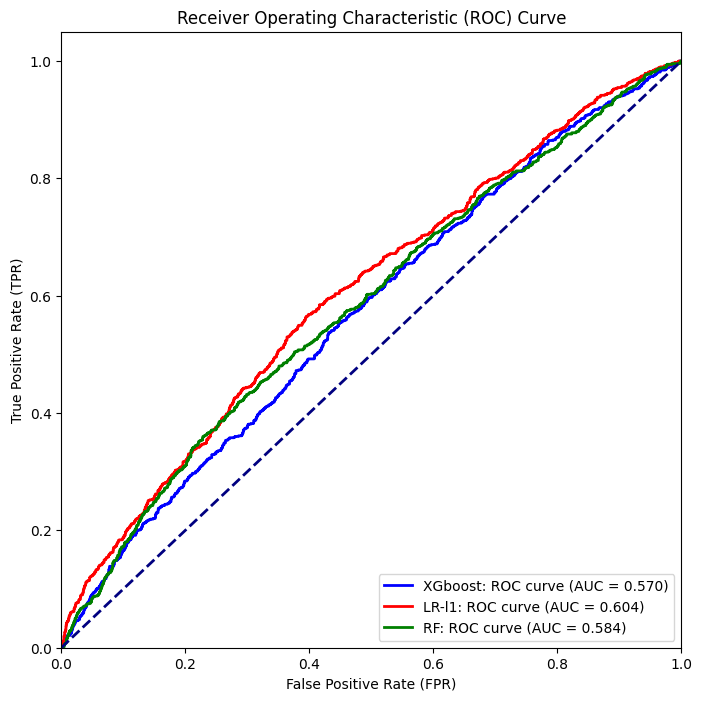

In [378]:
# Calculate ROC curve
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test['label'], xgb_y_test_pred)
l1_fpr, l1_tpr,l1_thresholds = roc_curve(y_test['label'], l1_y_test_pred)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test['label'], rf_y_test_pred)

# Calculate Area Under the Curve (AUC)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
l1_roc_auc = auc(l1_fpr, l1_tpr)
rf_roc_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(xgb_fpr, xgb_tpr, color='blue', lw=2, label=f'XGboost: ROC curve (AUC = {xgb_roc_auc:.3f})')
plt.plot(l1_fpr, l1_tpr, color='red', lw=2, label=f'LR-l1: ROC curve (AUC = {l1_roc_auc:.3f})')
plt.plot(rf_fpr, rf_tpr, color='green', lw=2, label=f'RF: ROC curve (AUC = {rf_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Confusion matrix

In [388]:
# Calculate the confusion matrix
y_pred = xgb_y_pred
confusion = confusion_matrix(y_test, y_pred)
# Extract TP, FN, FP, and TN from the confusion matrix
TP = confusion[1, 1]
FN = confusion[1, 0]
FP = confusion[0, 1]
TN = confusion[0, 0]

In [389]:
# Calculate Sensitivity (True Positive Rate)
sensitivity = TP / (TP + FN)
# Calculate Specificity (True Negative Rate)
specificity = TN / (TN + FP)
# Calculate PPV (Positive Predictive Value)
ppv = TP / (TP + FP)
# Calculate LPP (Likelihood of Positive Predictive)
NPV = TN / (TN+FN)

print(f"True Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV: {ppv:.4f}")
print(f"NPV: {NPV:.4f}")

True Positives (TP): 126
False Negatives (FN): 782
False Positives (FP): 193
True Negatives (TN): 2197
Sensitivity: 0.1388
Specificity: 0.9192
PPV: 0.3950
NPV: 0.7375


## Calibration plot

In [379]:
xgb_true_probabilities, xgb_predicted_probabilities = calibration_curve(y_test, xgb_y_test_pred, n_bins=10)
l1_true_probabilities, l1_predicted_probabilities = calibration_curve(y_test, l1_y_test_pred, n_bins=10)
rf_true_probabilities, rf_predicted_probabilities = calibration_curve(y_test, rf_y_test_pred, n_bins=10)

In [380]:
xgb_brier = brier_score_loss(y_test, xgb_y_test_pred)
l1_brier = brier_score_loss(y_test, l1_y_test_pred)
rf_brier = brier_score_loss(y_test, rf_y_test_pred)

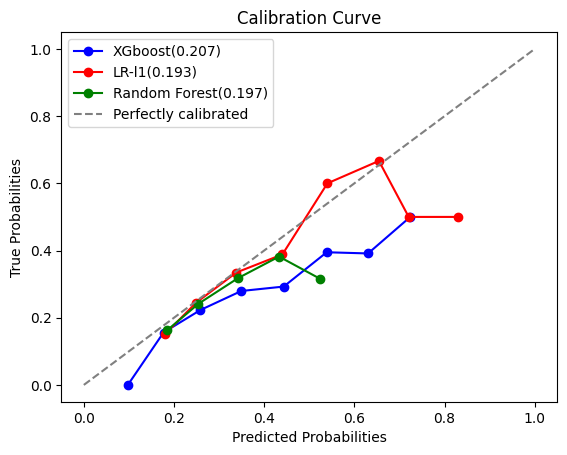

In [381]:
plt.plot(xgb_predicted_probabilities, xgb_true_probabilities, marker='o', color='blue', label='XGboost(' +  str(round(xgb_brier, 3)) + ')')
plt.plot(l1_predicted_probabilities, l1_true_probabilities, marker='o', color='red', label='LR-l1(' + str(round(l1_brier, 3)) + ')')
plt.plot(rf_predicted_probabilities, rf_true_probabilities, marker='o', color='green', label='Random Forest(' + str(round(rf_brier, 3)) + ')')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probabilities')
plt.ylabel('True Probabilities')
plt.title('Calibration Curve')
plt.legend()
plt.show()

## Net benefit

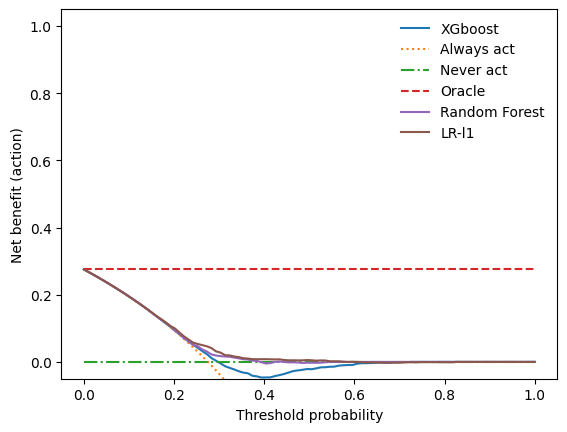

In [382]:
NetBenefitDisplay.from_predictions(y_test['label'], xgb_y_test_pred, name='XGboost')
NetBenefitDisplay.from_predictions(y_test['label'], rf_y_test_pred, name='Random Forest', show_references=False, ax=plt.gca())
NetBenefitDisplay.from_predictions(y_test['label'], l1_y_test_pred, name='LR-l1', show_references=False, ax=plt.gca())

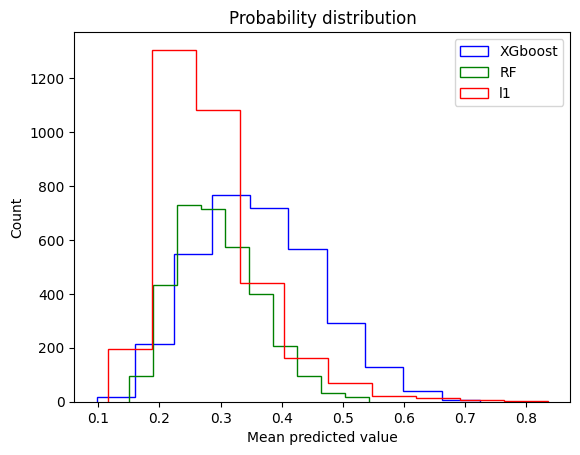

In [383]:
plt.hist(xgb_y_test_pred, bins=10, histtype='step', edgecolor='blue', label='XGboost')
plt.hist(rf_y_test_pred, bins=10, histtype='step', edgecolor='green', label='RF')
plt.hist(l1_y_test_pred, bins=10, histtype='step', edgecolor='red', label='l1')
plt.xlabel('Mean predicted value')
plt.ylabel('Count')
plt.title('Probability distribution')
plt.legend()
plt.show()